In [296]:
import numpy as np
import pandas as pd
from scipy import stats
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import itertools
from collections import Counter
from more_itertools import set_partitions
import copy
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("ticks")
plt.rcParams['font.family'] = 'serif'

Dataset of $j$-th client follows $D_j\sim (\theta_i,\epsilon_j^2)$.
The following code is to simulate:
- $\epsilon_j^2$: the amount of noise in the sampling process 
- $\theta_j$: the true mean of players

In [297]:
means_dist_1 = stats.norm(loc = 0, scale = 1)
means_dist_2 = stats.norm(loc = 0, scale =1)
variance_dist = stats.beta(a=8, b=2, scale = 1000/4)
print([means_dist_1.var(), means_dist_2.var()])
print(variance_dist.mean())

[1.0, 1.0]
200.0


Calculate the error of clients in a coalition structure

In [298]:
#Reference: [https://github.com/kpdonahue/model_sharing_games]
#Here is the function inspired by the above reference.
def calculate_regression(var_vec = [means_dist_1.var(), means_dist_2.var()], mue = variance_dist.mean(), 
                         n_list = [10, 20, 30], w_best=False,w_list = [0.2, 0.4, 0.6], 
                         v_best=False,v_mat = [[0.1, 0.6, 0.3], [0.2, 0.8, 0.0], [0.3, 0.5, 0.2]], 
                         x_vec = [1.0, 1.0],fair=False,err_list=None, q=0):
    '''
    Calculate exact error for linear regression, in special case where x-distribution is 0-mean multivariate 
    normal. Assumes the parameters have 0 correlation (parameter in 1st dimension is independent of parameter
    in 2nd dimension, for example). 

    Args:
        var_vec: a list with variance of true parameter values
        mue: mean of true error distribution. 
        n_list: a list of length M (number of players) with the number of samples each has. 
        w_list: a list of w-weights each player uses (in [0, 1]) for coarse-grained federation. 
        v_mat: a matrix (list of lists) of weights each player uses in fine-grained federation: the rows sum up 
               to 1.
        x_vec: a list of E[X_d^2] for d in dimension D for input distribution of X. 
    Returns:
        dataframe with average error for each player, for: local, uniform, coarse-grained, and fine-grained 
        federation.  
    '''
    # dataframe for storing error
    player_error = pd.DataFrame(data = 0.0, index = ['local', 'uniform', 'coarse', 'fine',"fair"], 
                                columns = range(len(n_list)))
    N = sum(n_list)
    D = len(var_vec)
    n_vec = pd.DataFrame(n_list)
    
    # for each player, calculate their true error 
    for i,n in enumerate(n_list):
        
        # n = n_list[i]
        
        
        # local
        player_error.loc['local'][i] = mue * D/(n - D - 1)
        
        # uniform
        var_prod = pd.DataFrame(x_vec).T.dot(pd.DataFrame(var_vec))[0][0]
        
        player_error.loc['uniform'][i] = ((mue * D * (n_vec**2).T.dot(1/(n_vec- D -1))/(N**2))[0][0] + 
                                          var_prod*((n_vec**2).sum() - n**2 + (N- n)**2)[0]/(N**2))
        
        # coarse-grained
        if w_best:
            # v_vec = pd.DataFrame(v_mat[i])
            w=w_list
            player_error.loc['coarse'][i] = ((mue*D *(1-w)**2 * (n_vec**2).T.dot(1/(n_vec- D -1))/(N**2))[0][0] + 
                                            mue*D*(w**2 + 2 * (1-w) * w*n/N)/(n-D-1) + 
                                            (1-w)**2*var_prod*((n_vec**2).sum() - n**2 + (N- n)**2)[0]/(N**2))    
        # fine-grained
        if v_best:
            v_vec = pd.DataFrame(v_mat[i])
            player_error.loc['fine'][i] = (mue * D * (v_vec**2).T.dot(1/(pd.DataFrame(n_list)- D -1))[0][0] + 
                                        var_prod * ((v_vec**2).sum() - v_vec[0][i]**2 + (1 - v_vec[0][i])**2)[0])
        if fair is True:
            v_vec = pd.DataFrame([ni*pow(err_i,q)/sum([ni*pow(err_i,q) for ni,err_i in zip(n_list,err_list)]) for ni,err_i in zip(n_list,err_list)])
            mu_co=(v_vec**2).T.dot(pd.DataFrame([D/(nval-D-1) for nval in n_list]))
            var_prod_con=((v_vec**2).sum() - v_vec.iloc[i]**2 + (1 - v_vec.iloc[i])**2)
            player_error.loc['fair'][i] = ((mue * mu_co)[0][0] + 
                                          var_prod*var_prod_con[0])
        
            
            
    return player_error

Collect errors in all possible coalition structures

In [299]:
#Reference: [https://github.com/kpdonahue/model_sharing_games]
#Here is the function inspired by the above reference.
def calc_error_groups(var_vec = [means_dist_1.var(),means_dist_2.var()], mue = variance_dist.mean(), same_size = False, 
                n = 10, M = 5, n_list = [10, 20, 30], fair=False, err_list=None, q=0):
    '''
    Calculates the errors that players experience, for all possible arrangements of players into groups. 
    Assumes optimal versions of coarse and fine federation are used. 
    
    Args:
        var: variance of mean parameter. 
        mue: mean of errors. 
        same_size: boolean, indicates whether all players are the same size (if so, runs faster). 
        n: if players are the same size, indicates the size
        M: if players are the same size, indicates the number of players
        n_list: if players differ in their size, provides a list of those sizes. 
        
    Returns: 
        tables with errors for every combination of players (uniform, coarse, and fine-grained federation), 
        as well as local learning.
        
    
    '''
    
    if same_size:
        # all players are interchangable
        n_list = [n for i in range(M)]
        comb = list(itertools.combinations_with_replacement([0,1], r=M))
    else: 
        # for combinations, the identity of player matters (not interchangable)
        # for example: [1, 0, 1] means a group made of 1st and 3rd players only
        comb = list(itertools.product([0,1], repeat = len(n_list)))
    
    string_list = ["".join(map(str, val)) for val in comb] # string to name groups
    err_uniform = pd.DataFrame(data = np.nan, 
                              index = string_list,
                              columns = ['n_' + str(i) + '_err' for i in n_list] )
    err_best_coarse = err_uniform.copy()
    err_best_fine = err_uniform.copy()
    err_fair=err_uniform.copy()
        
    for index, group in enumerate(comb):
        loca = "".join(map(str, group)) # group index
        if sum(group) > 0: # ignore group with no members
            
            # drop players not in this group
            temp_n = [n_list[i] for i in range(len(n_list)) if list(group)[i] == 1]
            
            # calculate error table and rename columns
            error_table = calculate_regression(var_vec= var_vec, mue = mue, n_list = temp_n, w_best = False, v_best = False,fair=fair,err_list=err_list,q=q)
            error_table.columns = [i for i in range(len(n_list)) if list(group)[i] == 1]  
            
            # copy errors into correct tables
            for player in range(len(n_list)):
                if list(group)[player] ==1: # if player is participating in group
                    err_uniform.iloc[index, player] = error_table.loc['uniform', player]
                    err_best_coarse.iloc[index, player] = error_table.loc['coarse', player]
                    err_best_fine.iloc[index, player] = error_table.loc['fine', player]
                    err_fair.iloc[index, player] = error_table.loc['fair', player]
    
    local_error = calculate_regression(var_vec=  var_vec, mue = mue, n_list = n_list, w_best = False, 
                                  v_best = False).loc['local']
    
    err_uniform.dropna(how = 'all', inplace = True)
    err_best_coarse.dropna(how = 'all', inplace = True)
    err_best_fine.dropna(how = 'all', inplace = True)
    err_fair.dropna(how = 'all', inplace = True)
    

    return err_uniform, err_best_coarse, err_best_fine, err_fair,local_error

Calculate utility in ACFG

In [300]:
def calc_unity_groups(err_uniform=None,same_size = False, 
            n = 10, M = 5, n_list = [1, 2], preference="selfish",friends=None,w=0.35,client_pre=None):
    if client_pre==None:
        client_pre=list(range(len(n_list)))
    if same_size:
        # all players are interchangable
        n_list = [n for i in range(M)]
        comb = list(itertools.combinations_with_replacement([0,1], r=M))
    else: 
        # for combinations, the identity of player matters (not interchangable)
        # for example: [1, 0, 1] means a group made of 1st and 3rd players only
        comb = list(itertools.product([0,1], repeat = len(n_list)))
    
    string_list = ["".join(map(str, val)) for val in comb] # string to name groups
    util_uniform = pd.DataFrame(data = np.nan, 
                              index = string_list,
                              columns = ['n_' + str(i) + '_err' for i in n_list] )
    util_uniform=copy.deepcopy(err_uniform)
    
    all_coalition = int('1' * len(n_list), 2)
    for index, row_name in enumerate(util_uniform.index):
        current_coalition= int(row_name, 2)
        complement_coalition = all_coalition - current_coalition
        complement_coalition = bin(complement_coalition)[2:]
        complement_coalition = complement_coalition.zfill(len(n_list))
        if sum([int(exist) for exist in complement_coalition])!=0:
            complement_index = util_uniform.index.get_loc(complement_coalition)
        else:
            complement_index=None
        
        # copy errors into correct tables
        for player in client_pre:
        # for player in range(len(n_list)):
            if list([exist for exist in row_name])[player]=="1": # if player is participating in group
                if preference=="mean-FR":
                    # if index=="00001":
                    #     print()
                    if complement_index!=None:
                        # print(err_uniform.iloc[index,player])
                        # print(pd.to_numeric(err_uniform.iloc[index,friends[str(player)]+[player]].replace("-", np.nan), errors='coerce'))
                        # print(pd.to_numeric(err_uniform.iloc[complement_index,friends[str(player)]].replace("-", np.nan), errors='coerce'))
                        util_uniform.iloc[index, player] =w*err_uniform.iloc[index,player]+(1-w)*(pd.to_numeric(err_uniform.iloc[index,friends[str(player)]+[player]].replace("-", np.nan), errors='coerce').sum(skipna=True)+pd.to_numeric(err_uniform.iloc[complement_index,friends[str(player)]].replace("-", np.nan), errors='coerce').sum(skipna=True))/(len(friends[str(player)])+1)
                        # print( util_uniform.iloc[index, player])
                    else:
                        util_uniform.iloc[index, player] =w*err_uniform.iloc[index,player]+(1-w)*pd.to_numeric(err_uniform.iloc[index,friends[str(player)]+[player]]).mean(skipna=True)
                        
                if preference=="min-FR":
                    if complement_index!=None:
                        util_uniform.iloc[index, player] =w*err_uniform.iloc[index,player]+(1-w)*np.nanmax([pd.to_numeric(err_uniform.iloc[index,friends[str(player)]+[player]].replace("-", np.nan), errors='coerce').max(skipna=True),pd.to_numeric(err_uniform.iloc[complement_index,friends[str(player)]].replace("-", np.nan), errors='coerce').max(skipna=True)])
                    else:
                        util_uniform.iloc[index, player] =w*err_uniform.iloc[index,player]+(1-w)*pd.to_numeric(err_uniform.iloc[index,friends[str(player)]+[player]]).max(skipna=True)
                if preference=="mean-PA": 
                    if complement_index!=None:
                        util_uniform.iloc[index, player] =(pd.to_numeric(err_uniform.iloc[index,friends[str(player)]].replace("-", np.nan), errors='coerce').sum(skipna=True)+pd.to_numeric(err_uniform.iloc[complement_index,friends[str(player)]].replace("-", np.nan), errors='coerce').sum(skipna=True))/len(friends[str(player)])
                    else:
                        util_uniform.iloc[index, player] =pd.to_numeric(err_uniform.iloc[index,friends[str(player)]]).mean(skipna=True)        
                
                if preference=="min-PA":
                    if complement_index!=None:
                        util_uniform.iloc[index, player]=np.nanmax([pd.to_numeric(err_uniform.iloc[index,friends[str(player)]].replace("-", np.nan), errors='coerce').max(skipna=True),pd.to_numeric(err_uniform.iloc[complement_index,friends[str(player)]].replace("-", np.nan), errors='coerce').max(skipna=True)])
                    else:
                        util_uniform.iloc[index, player] =pd.to_numeric(err_uniform.iloc[index,friends[str(player)]]).max(skipna=True)
                             
    
    return util_uniform

Check whether the grand coalition structure is stable? 

In [301]:
def check_stable(utility_uniform, utility_fair,structure):
    '''
    Check whether the grand coalition structure is stable
    
    Args:
        utility_uniform: Utility without considering fairness. 
        utility_fair: Utility  considering fairness. 
        structure:  all possible coalition structures
        
    Returns: 
        IF Stable? None/Subset
        
    
    '''
    row_ids = utility_uniform.index.tolist()
   
    grand_colition=row_ids[-1]
    grand_value=utility_fair.loc[grand_colition]
    for coalitions in structure:
        for coaltion in coalitions:
            not_nan_indices = utility_uniform.loc[coaltion].notna()

            check_less_equal = utility_uniform.loc[coaltion][not_nan_indices].le(grand_value[not_nan_indices])
            check_less = utility_uniform.loc[coaltion][not_nan_indices].lt(grand_value[not_nan_indices])

            all_columns_less_equal = check_less_equal.all()
            at_least_one_column_less = check_less.any()

            result = all_columns_less_equal and at_least_one_column_less

            if result:
                return coaltion
    return None

In [302]:
def check_same_position(str1, str2):
    for i in range(len(str1)):
        if str1[i] == '1' and str2[i] == '1':
            return 1
    return 0

def generate_combinations(numbers):
    target_decimal = pow(2,len(numbers[0]))-1 

    def backtrack(curr, idx,total):
        if total== target_decimal:
            combinations.append(curr)
            return
            
        exist=False
        if len(curr)!=0:
            for curr_i in curr:
                if check_same_position(curr_i,numbers[idx]):
                    exist=True
                
            
        if idx<len(numbers)-1:
            if exist==False:
                backtrack(curr+[numbers[idx]], idx + 1, total + int(numbers[idx], 2))
            backtrack(curr, idx + 1, total)
    combinations = []
    backtrack([], 0, 0)
    return combinations


In [303]:
# clients_dataset_num = [1,5,10,20]
clients_dataset_num = [50,100,200]

In [304]:
err_uniform, _, _, _,_ = calc_error_groups(n_list =clients_dataset_num)
err_uniform=err_uniform.replace([np.nan],['-'])
err_uniform

,n_50_err,n_100_err,n_200_err
001,-,-,2.030457
010,-,4.123711,-
011,-,3.138393,1.80506
100,8.510638,-,-
101,4.199918,-,1.799918
110,4.556165,3.222832,-
111,3.459037,2.887608,1.744751


In [305]:
row_ids = err_uniform.index.tolist()
row_ids

['001', '010', '011', '100', '101', '110', '111']

Calculate Optimal Egalitarian Fairness Bound $\lambda$

In [306]:
def get_coalitions(n_list, s_list):
    coalitions = []
    for s in s_list:
        indices = [i for i, x in enumerate(s) if x == '1']
        coalitions.append(n_list[indices])
    return coalitions

Test 1. **Calculated egalitarian fairness bound** in Selfish Clients v.s. **Obtained egalitarian fairness**

In [307]:
clients_dataset_array = np.array(clients_dataset_num)
coalitions_except_grand=get_coalitions(clients_dataset_array,row_ids[:-1])

m = np.argmin(clients_dataset_array)
l=np.argmax(clients_dataset_array)
N_g=np.sum(clients_dataset_array)
N_g_2_sum=np.sum(clients_dataset_array**2)
lambdas_cal=[]
for coalition in coalitions_except_grand:
    k = np.argmin(coalition)
    N_s=np.sum(coalition)
    N_s_2_sum=np.sum(coalition**2)
    lambdas_cal.append(max((N_s**2/N_g**2)*((N_g*clients_dataset_array[l]+N_g_2_sum-clients_dataset_array[m]**2+(N_g-clients_dataset_array[m])**2)/(N_s*clients_dataset_array[l]+N_s_2_sum-coalition[k]**2+(N_s-coalition[k])**2)),1))
    
    
lambda_cal= max(lambdas_cal)
lambda_cal

1.7142857142857142

In [308]:
err_list = err_uniform.iloc[-1].tolist()

q_list=np.arange(0,1,0.05).tolist()
lambda_list=[]
stable_list=[]


coalitions = generate_combinations(row_ids)

for q in q_list:
    err_uniform, _, _, err_fair,_ = calc_error_groups(n_list =clients_dataset_num,fair=True, err_list=err_list, q=q)
    err_fair_last_row=err_fair.iloc[-1]
    lambda_list.append(err_list[0]/err_fair_last_row[-1])
    stable_result=check_stable(err_uniform,err_fair,coalitions)
    stable_list.append(stable_result!=None)

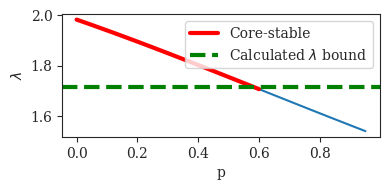

In [309]:


fig, ax = plt.subplots(figsize=(4,2))

ax.plot(q_list, lambda_list)

fair_condition = [index for index, element in enumerate(stable_list) if element == False]
ax.plot([q_list[i] for i in fair_condition] , [lambda_list[i] for i in fair_condition], color='red', linewidth=3, label='Core-stable')        
ax.axhline(y=lambda_cal, linewidth=3,color='green', linestyle='--',label='Calculated $\lambda$ bound')
plt.xlabel('p')
plt.ylabel('$\lambda$')
ax.legend() 
plt.tight_layout()
plt.savefig("selfish_reg.svg")
plt.show()

Test 2. **Calculated egalitarian fairness bound** in Purely Altruism v.s. **Obtained egalitarian fairness**

Full-connected Friendship

In [310]:
friends = {}
for i in range(len(clients_dataset_num)):
    friends[str(i)]=[]
    for j in range(len(clients_dataset_num)):
        if j!=i:
            friends[str(i)].append(j) 
friends
# friends={"0": [4,1], "1": [0,2],"2":[1,3],"3":[2,4],"4":[3,0]}

{'0': [1, 2], '1': [0, 2], '2': [0, 1]}

In [311]:
# friends = {}
# for i in range(len(clients_dataset_num)):
#     friends[str(i)]=[]
#     friends[str(i)].append((i+1)%len(clients_dataset_num)) 
#     # friends[str(i)].append((i+2)%len(clients_dataset_num)) 
#     friends[str(i)].append((i-1)%len(clients_dataset_num) )
# friends

In [312]:
# friends ={'0': [3, 3], '1': [2,2], '2': [3, 1], '3': [2,0]}

In [313]:
# clients_dataset_array = np.array(clients_dataset_num)
# coalitions_except_grand=get_coalitions(clients_dataset_array,row_ids[:-1])

# m = np.argmin(clients_dataset_array)
# l=np.argmax(clients_dataset_array)
# N_g=np.sum(clients_dataset_array)
# N_g_2_sum=np.sum(clients_dataset_array**2)
# lambdas_cal=[]
# friends_array=np.array([np.array(friends[str(i)]) for i in range(clients_dataset_array.shape[0])])
# friends_num_array=np.array([np.array([clients_dataset_array[f] for f in friends[str(i)]]) for i in range(clients_dataset_array.shape[0])])

# for i,coalition in enumerate(coalitions_except_grand):
#     if row_ids[i]=="10000":
#         print()
#     # k=np.argmin(np.min(friends_num_array, axis=1))
#     # f_opt=friends_array[k,np.argmin(friends_num_array[k])]  

#     # if  row_ids[i][f_opt]=="1":
#     #     N_s=np.sum(coalition)
#     #     N_s_2_sum=np.sum(coalition**2)
#     # else:
#     #     N_s=N_g-np.sum(coalition)
#     #     N_s_2_sum=N_g_2_sum-np.sum(coalition**2)
#     # k_list
#     c_in_c=[]
#     f_in_c=[]
#     f_in_c_num=[]
#     for j in range(len(row_ids[i])):
#         if row_ids[i][j]=="1":
#             c_in_c.append(j)
#             f_in_c.append(np.array([f  if row_ids[i][f]=="1" else None for f in friends[str(j)] ]))
#             # f_in_c_num.append(np.array([clients_dataset_array[f] if row_ids[i][f]=='1' else float('inf') for f in friends[str(j)]])
#             f_in_c_num.append(np.array([clients_dataset_array[f]  for f in friends[str(j)]])
# )
#     f_in_c=np.array(f_in_c)
#     f_in_c_num=np.array(f_in_c_num)
#     k = np.argmin(np.min(f_in_c_num, axis=1))
#     # f_opt=f_in_c[k,np.argmin(f_in_c_num[k])]
#     f_opt=friends_array[c_in_c[k],np.argmin(friends_num_array[c_in_c[k]])]
#     N_s=np.sum(coalition)
#     N_s_2_sum=np.sum(coalition**2)  
    
#     if row_ids[i][f_opt]=="0":
#         N_s=N_g-N_s
#         N_s_2_sum=N_g_2_sum-N_s_2_sum
#     if f_opt!=None:
#         lambdas_cal.append((N_s**2/N_g**2)*((N_g*clients_dataset_array[l]+N_g_2_sum-clients_dataset_array[m]**2+(N_g-clients_dataset_array[m])**2)/(N_s*clients_dataset_array[l]+N_s_2_sum-clients_dataset_array[f_opt]**2+(N_s-clients_dataset_array[f_opt])**2)))
        
# lambda_cal= max(lambdas_cal) 
# lambda_cal

In [314]:
clients_dataset_array = np.array(clients_dataset_num)
coalitions_except_grand=get_coalitions(clients_dataset_array,row_ids[:-1])

m = np.argmin(clients_dataset_array)
l=np.argmax(clients_dataset_array)
N_g=np.sum(clients_dataset_array)
N_g_2_sum=np.sum(clients_dataset_array**2)
lambdas_cal=[]
friends_array=np.array([np.array(friends[str(i)]) for i in range(clients_dataset_array.shape[0])])
friends_num_array=np.array([np.array([clients_dataset_array[f] for f in friends[str(i)]]) for i in range(clients_dataset_array.shape[0])])

for i,coalition in enumerate(coalitions_except_grand):
    # k=np.argmin(np.min(friends_num_array, axis=1))
    # f_opt=friends_array[k,np.argmin(friends_num_array[k])]  

    # if  row_ids[i][f_opt]=="1":
    #     N_s=np.sum(coalition)
    #     N_s_2_sum=np.sum(coalition**2)
    # else:
    #     N_s=N_g-np.sum(coalition)
    #     N_s_2_sum=N_g_2_sum-np.sum(coalition**2)
    # k_list
    c_in_c=[]
    f_in_c=[]
    f_in_c_num=[]
    f_not_in_c=[]
    f_not_in_c_num=[]
    for j in range(len(row_ids[i])):
        if row_ids[i][j]=="1":
            c_in_c.append(j)
            f_in_c.append(np.array([f  if row_ids[i][f]=="1" else None for f in friends[str(j)] ]))
            f_not_in_c.append(np.array([f  if row_ids[i][f]=="0" else None for f in friends[str(j)] ]))
            f_in_c_num.append(np.array([clients_dataset_array[f] if row_ids[i][f]=='1' else float('inf') for f in friends[str(j)]]))
            f_not_in_c_num.append(np.array([clients_dataset_array[f] if row_ids[i][f]=='0' else float('inf') for f in friends[str(j)]]))
            # f_in_c_num.append(np.array([clients_dataset_array[f]  for f in friends[str(j)]])

    f_in_c=np.array(f_in_c)
    f_in_c_num=np.array(f_in_c_num)
    f_not_in_c=np.array(f_not_in_c)
    f_not_in_c_num=np.array(f_not_in_c_num)
    k_1 = np.argmin(np.min(f_in_c_num, axis=1))
    k_2 = np.argmin(np.min(f_not_in_c_num, axis=1))
    # f_opt=f_in_c[k,np.argmin(f_in_c_num[k])]
    f_opt_1=f_in_c[k_1,np.argmin(f_in_c_num[k_1])]
    f_opt_2=f_not_in_c[k_2,np.argmin(f_not_in_c_num[k_2])]

    N_s=np.sum(coalition)
    N_s_2_sum=np.sum(coalition**2)  
    Not_N_s=N_g-N_s
    Not_N_s_2_sum=N_g_2_sum-N_s_2_sum

    lambda1=lambda2=float('inf')
    if f_opt_1!=None:
        lambda1=(N_s**2/N_g**2)*((N_g*clients_dataset_array[l]+N_g_2_sum-clients_dataset_array[m]**2+(N_g-clients_dataset_array[m])**2)/(N_s*clients_dataset_array[l]+N_s_2_sum-clients_dataset_array[f_opt_1]**2+(N_s-clients_dataset_array[f_opt_1])**2))
    if f_opt_2!=None:
        lambda2=(Not_N_s**2/N_g**2)*((N_g*clients_dataset_array[l]+N_g_2_sum-clients_dataset_array[m]**2+(N_g-clients_dataset_array[m])**2)/(Not_N_s*clients_dataset_array[l]+Not_N_s_2_sum-clients_dataset_array[f_opt_2]**2+(Not_N_s-clients_dataset_array[f_opt_2])**2))


    lambdas_cal.append(min(lambda1,lambda2))
        
lambda_cal= max(lambdas_cal) 
lambda_cal

1.1020408163265307

In [315]:
q_list=np.arange(0,4,0.1).tolist()
lambda_list=[]
stable_list=[]

coalitions = generate_combinations(row_ids)
err_uniform, _, _, _,_ = calc_error_groups( n_list = clients_dataset_array)
err_list = err_uniform.iloc[-1].tolist()
util_uniform_ACFG_min_FR=calc_unity_groups(err_uniform=err_uniform, n_list = clients_dataset_array, preference="min-PA",friends=friends)
for q in q_list:
    _, _, _, err_fair,_ = calc_error_groups( n_list = clients_dataset_array,fair=True, err_list=err_list,q=q)
    util_uniform_ACFG_min_FR_i=calc_unity_groups(err_uniform=err_fair, n_list = clients_dataset_array, preference="min-PA",friends=friends)
    
    err_fair_last_row=err_fair.iloc[-1]
    lambda_list.append(err_list[0]/err_fair_last_row[-1])

    stable_result=check_stable(util_uniform_ACFG_min_FR,util_uniform_ACFG_min_FR_i,coalitions)
    stable_list.append(stable_result!=None)

    # print(err_fair)
    # print(stable_result)
    # print(util_uniform_ACFG_min_FR_i)
    # print(max(err_list)/min(err_fair_last_row))

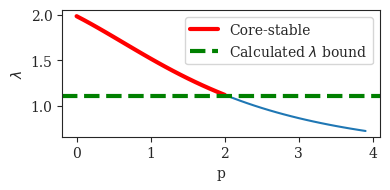

In [316]:
fig, ax = plt.subplots(figsize=(4,2))

ax.plot(q_list, lambda_list)

fair_condition = [index for index, element in enumerate(stable_list) if element == False]
ax.plot([q_list[i] for i in fair_condition] , [lambda_list[i] for i in fair_condition], color='red', linewidth=3, label='Core-stable')        
ax.axhline(y=lambda_cal, linewidth=3,color='green', linestyle='--',label='Calculated $\lambda$ bound')
plt.xlabel('p')
plt.ylabel('$\lambda$')
ax.legend() 
plt.tight_layout()
# plt.savefig("pwa_reg.svg")
plt.savefig("pwa_reg.svg")
plt.show()

Test 3. **Calculated egalitarian fairness bound** in Friendly Welfare Altruism v.s. **Obtained egalitarian fairness**

In [317]:
w=0.35

In [318]:
clients_dataset_array = np.array(clients_dataset_num)
coalitions_except_grand=get_coalitions(clients_dataset_array,row_ids[:-1])

m = np.argmin(clients_dataset_array)
l=np.argmax(clients_dataset_array)
N_g=np.sum(clients_dataset_array)
N_g_2_sum=np.sum(clients_dataset_array**2)
lambdas_cal=[]
friends_array=np.array([np.array(friends[str(i)]) for i in range(clients_dataset_array.shape[0])])
friends_num_array=np.array([np.array([clients_dataset_array[f] for f in friends[str(i)]]) for i in range(clients_dataset_array.shape[0])])

for i,coalition in enumerate(coalitions_except_grand):
    N_s=np.sum(coalition)
    N_s_2_sum=np.sum(coalition**2)  
    Not_N_s=N_g-N_s
    Not_N_s_2_sum=N_g_2_sum-N_s_2_sum

    c_in_s=[]
    c_and_f_num=[]
    c_and_f_not_num=[]
    c_and_f_num_sum=[]
    c_and_f_not_num_sum=[]

    for j in range(len(row_ids[i])):
        if row_ids[i][j]=="1":
            c_in_s.append(j)
            c_and_f_num_sum_i=[float('inf') for c_i in range(len(clients_dataset_num))]

            c_and_f_num_sum_i[j]=clients_dataset_array[j]
            for f in friends[str(j)] :
                if row_ids[i][f]=='1':
                    c_and_f_num_sum_i[f]=clients_dataset_array[f]
                else:
                    c_and_f_num_sum_i[f]=float('inf')
            c_and_f_num.append(np.array(c_and_f_num_sum_i))

        
            c_and_f_not_num_sum_i=[float('inf') for c_i in range(len(clients_dataset_num))]
            c_and_f_not_num_sum_i[j]=clients_dataset_array[j]
            for f in friends[str(j)] :
                if row_ids[i][f]=='0':
                    c_and_f_not_num_sum_i[f]=clients_dataset_array[f]
                else:
                    c_and_f_not_num_sum_i[f]=float('inf')
            c_and_f_not_num.append(np.array(c_and_f_not_num_sum_i))

            c_and_f_num_sum.append(w*clients_dataset_array[j]+(1-w)*min([clients_dataset_array[j]]+[clients_dataset_array[f]   for f in friends[str(j)] if row_ids[i][f]=='1' ]))
            c_and_f_not_num_sum.append(w*clients_dataset_array[j]/N_s+(1-w)*min([clients_dataset_array[j]/N_s]+[clients_dataset_array[f]/Not_N_s   for f in friends[str(j)] if row_ids[i][f]=='0' ]))
            
            # c_and_f_num_sum.append(w*clients_dataset_array[j]+(1-w)*min([clients_dataset_array[j]]+[clients_dataset_array[f]   for f in friends[str(j)] if row_ids[i][f]=='1' ]))
            # c_and_f_not_num_sum.append(w*clients_dataset_array[j]+(1-w)*min([clients_dataset_array[j]]+[clients_dataset_array[f]   for f in friends[str(j)] if row_ids[i][f]=='0' ]))

    # k=np.argmin(np.mean(f_in_c_num+f_not_in_c_num*(N_s)/(Not_N_s), axis=1))
    
    k1=np.argmin(np.array(c_and_f_num_sum))
    k2=np.argmin(np.array(c_and_f_not_num_sum))

    f1=np.argmin(c_and_f_num[k1])
    f2=np.argmin(c_and_f_not_num[k2])
    # k = np.argmin(np.mean(f_in_c_num, axis=1)+np.mean(f_not_in_c_num, axis=1))
    
    lambda1=(N_s**2)*(N_g*clients_dataset_array[l]+N_g_2_sum-clients_dataset_array[m]**2+(N_g-clients_dataset_array[m])**2)/((N_g**2)*((N_s*clients_dataset_array[l])+w*(N_s_2_sum-clients_dataset_array[c_in_s[k1]]**2+(N_s-clients_dataset_array[c_in_s[k1]])**2)+(1-w)*(N_s_2_sum-clients_dataset_array[f1]**2+(N_s-clients_dataset_array[f1])**2)))


    lambda2=(N_s**2*Not_N_s**2)*(N_g*clients_dataset_array[l]+N_g_2_sum-clients_dataset_array[m]**2+(N_g-clients_dataset_array[m])**2)/((N_g**2)*(Not_N_s**2*w*(N_s*clients_dataset_array[l]+(N_s_2_sum-clients_dataset_array[c_in_s[k2]]**2+(N_s-clients_dataset_array[c_in_s[k2]])**2))+N_s**2*(1-w)*(Not_N_s*clients_dataset_array[l]+Not_N_s_2_sum-clients_dataset_array[f2]**2+(Not_N_s-clients_dataset_array[f2])**2)))

    
    lambdas_cal.append(min(lambda1,lambda2))
        
lambda_cal= max(lambdas_cal) 
lambda_cal

0.955329500221141

In [319]:
q_list=np.arange(2,6,0.1).tolist()
lambda_list=[]
stable_list=[]

coalitions = generate_combinations(row_ids)
err_uniform, _, _, _,_ = calc_error_groups( n_list = clients_dataset_array)
err_list = err_uniform.iloc[-1].tolist()
util_uniform_ACFG_min_FR=calc_unity_groups(err_uniform=err_uniform, n_list = clients_dataset_array, preference="min-FR",friends=friends,w=w)
for q in q_list:
    _, _, _, err_fair,_ = calc_error_groups( n_list = clients_dataset_array,fair=True, err_list=err_list,q=q)
    util_uniform_ACFG_min_FR_i=calc_unity_groups(err_uniform=err_fair, n_list = clients_dataset_array, preference="min-FR",friends=friends,w=w)
    
    err_fair_last_row=err_fair.iloc[-1]
    lambda_list.append(err_list[0]/err_fair_last_row[-1])

    stable_result=check_stable(util_uniform_ACFG_min_FR,util_uniform_ACFG_min_FR_i,coalitions)
    stable_list.append(stable_result!=None)

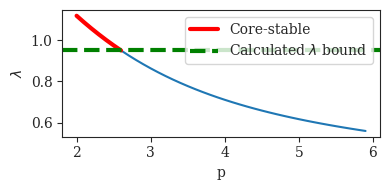

In [320]:
fig, ax = plt.subplots(figsize=(4,2))

ax.plot(q_list, lambda_list)

fair_condition = [index for index, element in enumerate(stable_list) if element == False]
ax.plot([q_list[i] for i in fair_condition] , [lambda_list[i] for i in fair_condition], color='red', linewidth=3, label='Core-stable')        
ax.axhline(y=lambda_cal, linewidth=3,color='green', linestyle='--',label='Calculated $\lambda$ bound')
plt.xlabel('p')
plt.ylabel('$\lambda$')
ax.legend() 
plt.tight_layout()
plt.savefig("fwa_reg.svg")
plt.show()

Test 4. **Calculated egalitarian fairness bound** in Purely Equal Altruism v.s. **Obtained egalitarian fairness**

In [321]:
clients_dataset_array = np.array(clients_dataset_num)
coalitions_except_grand=get_coalitions(clients_dataset_array,row_ids[:-1])

m = np.argmin(clients_dataset_array)
l=np.argmax(clients_dataset_array)
N_g=np.sum(clients_dataset_array)
N_g_2_sum=np.sum(clients_dataset_array**2)
lambdas_cal=[]
friends_array=np.array([np.array(friends[str(i)]) for i in range(clients_dataset_array.shape[0])])
friends_num_array=np.array([np.array([clients_dataset_array[f] for f in friends[str(i)]]) for i in range(clients_dataset_array.shape[0])])

for i,coalition in enumerate(coalitions_except_grand):
    N_s=np.sum(coalition)
    N_s_2_sum=np.sum(coalition**2)  
    Not_N_s=N_g-N_s
    Not_N_s_2_sum=N_g_2_sum-N_s_2_sum

    f_in_c=[]
    f_all=[]
    f_in_c=[]
    f_not_in_c=[]
    f_in_c_num=[]
    f_not_in_c_num=[]
    f_stat=[]
    for j in range(len(row_ids[i])):
        if row_ids[i][j]=="1":
            f_stat.append([len(friends[str(j)])])
            f_all.append(np.array([f  for f in friends[str(j)] ]))
            f_in_c.append(np.array([f  if row_ids[i][f]=="1" else None for f in friends[str(j)] ]))
            f_not_in_c.append(np.array([f  if row_ids[i][f]=="0" else None for f in friends[str(j)] ]))
            f_in_c_num.append(np.array([clients_dataset_array[f] if row_ids[i][f]=='1' else 0  for f in friends[str(j)] ]))
            f_not_in_c_num.append(np.array([clients_dataset_array[f]  if row_ids[i][f]=='0' else 0 for f in friends[str(j)]] ))

    f_stat=np.array(f_stat)
    f_all=np.array(f_all)
    f_in_c=np.array(f_in_c)
    f_not_in_c=np.array(f_not_in_c)
    f_in_c_num=np.array(f_in_c_num)
    f_not_in_c_num=np.array(f_not_in_c_num)


    k=np.argmin(np.sum(f_in_c_num/N_s+f_not_in_c_num/Not_N_s,axis=1).reshape(-1,1)/f_stat.reshape(-1,1))
    

    f_k_num=len(f_all[k].tolist())
    sum_c_in_s=sum([N_s*clients_dataset_array[l]+N_s_2_sum-clients_dataset_array[f]**2+(N_s-clients_dataset_array[f])**2 for f in f_in_c[k].tolist()  if f!=None])
    sum_c_not_in_s=sum([Not_N_s*clients_dataset_array[l]+Not_N_s_2_sum-clients_dataset_array[f]**2+(Not_N_s-clients_dataset_array[f])**2 for f in f_not_in_c[k].tolist() if f!=None ])
    
    lambda1=f_k_num*(N_s**2)*(Not_N_s**2)*(N_g*clients_dataset_array[l]+N_g_2_sum-clients_dataset_array[m]**2+(N_g-clients_dataset_array[m])**2)/((N_g**2)*((Not_N_s**2)*sum_c_in_s+(N_s**2)*sum_c_not_in_s))
    
    # if row_ids[i]=="1000":
    # sum_c_in_s1=[100/N_s+(N_s_2_sum-clients_dataset_array[f]**2+(N_s-clients_dataset_array[f])**2)/N_s**2 for f in f_in_c[k].tolist()  if f!=None]
    # sum_c_not_in_s1=[100/Not_N_s+(Not_N_s_2_sum-clients_dataset_array[f]**2+(Not_N_s-clients_dataset_array[f])**2)/Not_N_s**2 for f in f_not_in_c[k].tolist() if f!=None ]
    
    # sum_c_in_s1=sum([100/N_s+(N_s_2_sum-clients_dataset_array[f]**2+(N_s-clients_dataset_array[f])**2)/N_s**2 for f in f_in_c[k].tolist()  if f!=None])
    # sum_c_not_in_s1=sum([100/Not_N_s+(Not_N_s_2_sum-clients_dataset_array[f]**2+(Not_N_s-clients_dataset_array[f])**2)/Not_N_s**2 for f in f_not_in_c[k].tolist() if f!=None ])
    
    # lambda_true=(100/N_g+(N_g_2_sum-clients_dataset_array[m]**2+(N_g-clients_dataset_array[m])**2)/N_g**2)/((sum_c_in_s1+sum_c_not_in_s1)/3)

    # lambdas_cal.append([lambda1,lambda_true])
    lambdas_cal.append(lambda1)
        
lambda_cal= max(lambdas_cal) 
lambda_cal

1.4025974025974026

In [322]:
q_list=np.arange(0,4,0.1).tolist()
lambda_list=[]
stable_list=[]

coalitions = generate_combinations(row_ids)
err_uniform, _, _, _,_ = calc_error_groups( n_list = clients_dataset_array)
err_list = err_uniform.iloc[-1].tolist()
util_uniform_ACFG_min_FR=calc_unity_groups(err_uniform=err_uniform, n_list = clients_dataset_array, preference="mean-PA",friends=friends)
for q in q_list:
    err_uniform2, _, _, err_fair,_ = calc_error_groups( n_list = clients_dataset_array,fair=True, err_list=err_list,q=q)
    util_uniform_ACFG_min_FR_i=calc_unity_groups(err_uniform=err_fair, n_list = clients_dataset_array, preference="mean-PA",friends=friends)
    
    err_fair_last_row=err_fair.iloc[-1]
    lambda_list.append(err_list[0]/err_fair_last_row[-1])

    stable_result=check_stable(util_uniform_ACFG_min_FR,util_uniform_ACFG_min_FR_i,coalitions)
    stable_list.append(stable_result!=None)
    
    # print("err_uniform2", err_uniform2)
    # print("err_fair", err_fair)
    # print("util_uniform_ACFG_min_FR",util_uniform_ACFG_min_FR)
    # print(stable_result)
    # print("util_uniform_ACFG_min_FR_i", util_uniform_ACFG_min_FR_i)
    # print(err_list[0]/err_fair_last_row[-1])
    
    # if stable_result!=None:
    #     print()

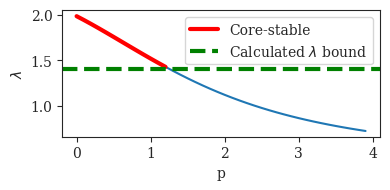

In [323]:
fig, ax = plt.subplots(figsize=(4,2))

ax.plot(q_list, lambda_list)

fair_condition = [index for index, element in enumerate(stable_list) if element == False]
fair_condition.append(len(fair_condition))
ax.plot([q_list[i] for i in fair_condition] , [lambda_list[i] for i in fair_condition], color='red', linewidth=3, label='Core-stable')        
ax.axhline(y=lambda_cal, linewidth=3,color='green', linestyle='--',label='Calculated $\lambda$ bound')
plt.xlabel('p')
plt.ylabel('$\lambda$')
ax.legend() 
plt.tight_layout()
plt.savefig("pea_reg.svg")
plt.show()

Test 5. **Calculated egalitarian fairness bound** in Friendly Equal Altruism v.s. **Obtained egalitarian fairness**

In [324]:
# clients_dataset_array = np.array(clients_dataset_num)
# coalitions_except_grand=get_coalitions(clients_dataset_array,row_ids[:-1])

# m = np.argmin(clients_dataset_array)
# l=np.argmax(clients_dataset_array)
# N_g=np.sum(clients_dataset_array)
# N_g_2_sum=np.sum(clients_dataset_array**2)
# lambdas_cal=[]
# friends_array=np.array([np.array(friends[str(i)]) for i in range(clients_dataset_array.shape[0])])
# friends_num_array=np.array([np.array([clients_dataset_array[f] for f in friends[str(i)]]) for i in range(clients_dataset_array.shape[0])])

# for i,coalition in enumerate(coalitions_except_grand):
#     N_s=np.sum(coalition)
#     N_s_2_sum=np.sum(coalition**2)  
#     Not_N_s=N_g-N_s
#     Not_N_s_2_sum=N_g_2_sum-N_s_2_sum
#     # k=np.argmin(np.min(friends_num_array, axis=1))
#     # f_opt=friends_array[k,np.argmin(friends_num_array[k])]  

#     # if  row_ids[i][f_opt]=="1":
#     #     N_s=np.sum(coalition)
#     #     N_s_2_sum=np.sum(coalition**2)
#     # else:
#     #     N_s=N_g-np.sum(coalition)
#     #     N_s_2_sum=N_g_2_sum-np.sum(coalition**2)
#     # k_list
#     c_in_s=[]
#     f_in_c=[]
#     f_num=[]
#     f_all=[]
#     f_in_c=[]
#     f_not_in_c=[]
#     f_in_c_num=[]
#     f_not_in_c_num=[]
#     f_stat=[]
#     for j in range(len(row_ids[i])):
        
#         if row_ids[i][j]=="1":
#             c_in_s.append(np.array([clients_dataset_num[j]]))
#             f_all.append(np.array([f  for f in friends[str(j)] ]))
#             f_stat.append([len(friends[str(j)])])
#             f_num.append(np.array([clients_dataset_array[f]  for f in friends[str(j)]]))
#             f_in_c.append(np.array([f  if row_ids[i][f]=="1" else None for f in friends[str(j)] ]))
#             f_not_in_c.append(np.array([f  if row_ids[i][f]=="0" else None for f in friends[str(j)] ]))
#             f_in_c_num.append(np.array([clients_dataset_array[f] if row_ids[i][f]=='1' else 0  for f in friends[str(j)] ]))
#             f_not_in_c_num.append(np.array([clients_dataset_array[f]  if row_ids[i][f]=='0' else 0 for f in friends[str(j)]] ))
#             # f_in_c_num.append(np.array([clients_dataset_array[f]  for f in friends[str(j)]])
#     c_in_s=np.array(c_in_s)
#     f_stat=np.array(f_stat)
#     f_all=np.array(f_all)
#     f_num=np.array(f_num)
#     f_in_c=np.array(f_in_c)
#     f_not_in_c=np.array(f_not_in_c)
#     f_in_c_num=np.array(f_in_c_num)
#     f_not_in_c_num=np.array(f_not_in_c_num)
#     t=f_not_in_c_num*(N_s)/(Not_N_s)
#     # k=np.argmin(np.mean(f_in_c_num+f_not_in_c_num*(N_s)/(Not_N_s), axis=1))
#     # k=np.argmin(w*c_in_s/N_s+(1-w)*((c_in_s+np.sum(f_in_c_num,axis=1).reshape(-1,1))/N_s+np.sum(f_not_in_c_num,axis=1).reshape(-1,1)/Not_N_s)/(f_stat+1))
   
#     k=np.argmin(w*c_in_s/N_s+(1-w)*((c_in_s+np.sum(f_in_c_num,axis=1).reshape(-1,1))/N_s+np.sum(f_not_in_c_num,axis=1).reshape(-1,1)/Not_N_s)/(f_stat+1))
#     # print(k)
#     # k=np.argmin(w*c_in_s/N_s+(1-w)*((c_in_s+np.sum(f_in_c_num,axis=1))/N_s+np.sum(f_not_in_c_num,axis=1)/Not_N_s)/(f_stat+1))
#     # print(w*c_in_s/N_s+(1-w)*((c_in_s+np.sum(f_in_c_num,axis=1))/N_s+np.sum(f_not_in_c_num,axis=1)/Not_N_s)/(f_stat+1))
#     # k=np.argmin(np.mean(f_in_c_num/N_s+f_not_in_c_num/Not_N_s, axis=1))
#     # k = np.argmin(np.mean(f_in_c_num, axis=1)+np.mean(f_not_in_c_num, axis=1))
    
   

#     f_k_num=len(f_all[k].tolist())
#     sum_c_in_s=sum([N_s*clients_dataset_array[l]+N_s_2_sum-clients_dataset_array[f]**2+(N_s-clients_dataset_array[f])**2 for f in f_in_c[k].tolist()  if f!=None])+(N_s*clients_dataset_array[l]+N_s_2_sum-coalition[k]**2+(N_s-coalition[k])**2)
#     sum_c_not_in_s=sum([Not_N_s*clients_dataset_array[l]+Not_N_s_2_sum-clients_dataset_array[f]**2+(Not_N_s-clients_dataset_array[f])**2 for f in f_not_in_c[k].tolist() if f!=None ])
    
#     lambda1=(f_k_num+1)*(N_s**2)*(Not_N_s**2)*(N_g*clients_dataset_array[l]+N_g_2_sum-clients_dataset_array[m]**2+(N_g-clients_dataset_array[m])**2)/((N_g**2)*(w*(f_k_num+1)*(Not_N_s**2)*(N_s*clients_dataset_array[l]+N_s_2_sum-coalition[k]**2+(N_s-coalition[k])**2)+(1-w)*(Not_N_s**2*sum_c_in_s+N_s**2*sum_c_not_in_s) ))
    
#     lambda2=(N_s**2/N_g**2)*((N_g*clients_dataset_array[l]+N_g_2_sum-clients_dataset_array[m]**2+(N_g-clients_dataset_array[m])**2)/(N_s*clients_dataset_array[l]+N_s_2_sum-coalition[k]**2+(N_s-coalition[k])**2))
#     lambdas_cal.append(lambda1)
# lambda_cal= max(lambdas_cal) 
# lambda_cal

In [325]:
clients_dataset_array = np.array(clients_dataset_num)
coalitions_except_grand=get_coalitions(clients_dataset_array,row_ids[:-1])

m = np.argmin(clients_dataset_array)
l=np.argmax(clients_dataset_array)
N_g=np.sum(clients_dataset_array)
N_g_2_sum=np.sum(clients_dataset_array**2)
lambdas_cal=[]

for i,coalition in enumerate(coalitions_except_grand):
    N_s=np.sum(coalition)
    N_s_2_sum=np.sum(coalition**2)  
    Not_N_s=N_g-N_s
    Not_N_s_2_sum=N_g_2_sum-N_s_2_sum
    # k=np.argmin(np.min(friends_num_array, axis=1))
    # f_opt=friends_array[k,np.argmin(friends_num_array[k])]  

    # if  row_ids[i][f_opt]=="1":
    #     N_s=np.sum(coalition)
    #     N_s_2_sum=np.sum(coalition**2)
    # else:
    #     N_s=N_g-np.sum(coalition)
    #     N_s_2_sum=N_g_2_sum-np.sum(coalition**2)
    # k_list
    c_in_s=[]
    f_in_c=[]
    f_num=[]
    f_all=[]
    f_in_c=[]
    f_not_in_c=[]
    f_in_c_num=[]
    f_not_in_c_num=[]
    f_stat=[]
    for j in range(len(row_ids[i])):
        
        if row_ids[i][j]=="1":
            c_in_s.append(np.array([clients_dataset_num[j]]))
            f_all.append([f for f in friends[str(j)] ])
            f_stat.append([len(friends[str(j)])])
            f_num.append(np.array([clients_dataset_array[f]  for f in friends[str(j)]]))
            f_in_c.append(np.array([f  if row_ids[i][f]=="1" else None for f in friends[str(j)] ]))
            f_not_in_c.append(np.array([f  if row_ids[i][f]=="0" else None for f in friends[str(j)] ]))
            f_in_c_num.append(np.array(sum([clients_dataset_array[f] if row_ids[i][f]=='1' else 0  for f in friends[str(j)] ])))
            
            f_not_in_c_num.append(np.array(sum([clients_dataset_array[f]  if row_ids[i][f]=='0' else 0 for f in friends[str(j)]]) ))

            # f_in_c_num.append(np.array([clients_dataset_array[f]  for f in friends[str(j)]])
           
    c_in_s=np.array(c_in_s)
    f_stat=np.array(f_stat)

    f_in_c_num=np.array(f_in_c_num)
    f_not_in_c_num=np.array(f_not_in_c_num)
    # k=np.argmin(np.mean(f_in_c_num+f_not_in_c_num*(N_s)/(Not_N_s), axis=1))
    # k=np.argmin(w*c_in_s/N_s+(1-w)*((c_in_s+np.sum(f_in_c_num,axis=1).reshape(-1,1))/N_s+np.sum(f_not_in_c_num,axis=1).reshape(-1,1)/Not_N_s)/(f_stat+1))

    k=np.argmin(w*c_in_s/N_s+(1-w)*((c_in_s+f_in_c_num.reshape(-1,1))/N_s+f_not_in_c_num.reshape(-1,1)/Not_N_s)/(f_stat+1))
    # print(k)
    # k=np.argmin(w*c_in_s/N_s+(1-w)*((c_in_s+np.sum(f_in_c_num,axis=1))/N_s+np.sum(f_not_in_c_num,axis=1)/Not_N_s)/(f_stat+1))
    # print(w*c_in_s/N_s+(1-w)*((c_in_s+np.sum(f_in_c_num,axis=1))/N_s+np.sum(f_not_in_c_num,axis=1)/Not_N_s)/(f_stat+1))
    # k=np.argmin(np.mean(f_in_c_num/N_s+f_not_in_c_num/Not_N_s, axis=1))
    # k = np.argmin(np.mean(f_in_c_num, axis=1)+np.mean(f_not_in_c_num, axis=1))
    
    f_k_num=len(f_all[k])
    sum_c_in_s=sum([N_s*clients_dataset_array[l]+N_s_2_sum-clients_dataset_array[f]**2+(N_s-clients_dataset_array[f])**2 for f in f_in_c[k]  if f!=None])+(N_s*clients_dataset_array[l]+N_s_2_sum-coalition[k]**2+(N_s-coalition[k])**2)
    sum_c_not_in_s=sum([Not_N_s*clients_dataset_array[l]+Not_N_s_2_sum-clients_dataset_array[f]**2+(Not_N_s-clients_dataset_array[f])**2 for f in f_not_in_c[k] if f!=None ])
    
    lambda1=(f_k_num+1)*(N_s**2)*(Not_N_s**2)*(N_g*clients_dataset_array[l]+N_g_2_sum-clients_dataset_array[m]**2+(N_g-clients_dataset_array[m])**2)/((N_g**2)*(w*(f_k_num+1)*(Not_N_s**2)*(N_s*clients_dataset_array[l]+N_s_2_sum-coalition[k]**2+(N_s-coalition[k])**2)+(1-w)*(Not_N_s**2*sum_c_in_s+N_s**2*sum_c_not_in_s) ))
    
    lambda2=(N_s**2/N_g**2)*((N_g*clients_dataset_array[l]+N_g_2_sum-clients_dataset_array[m]**2+(N_g-clients_dataset_array[m])**2)/(N_s*clients_dataset_array[l]+N_s_2_sum-coalition[k]**2+(N_s-coalition[k])**2))
    lambdas_cal.append(lambda1)
lambda_cal= max(lambdas_cal) 
lambda_cal

1.2375859434682963

In [326]:
# clients_dataset_array = np.array(clients_dataset_num)
# coalitions_except_grand=get_coalitions(clients_dataset_array,row_ids[:-1])

# m = np.argmin(clients_dataset_array)
# l=np.argmax(clients_dataset_array)
# N_g=np.sum(clients_dataset_array)
# N_g_2_sum=np.sum(clients_dataset_array**2)
# lambdas_cal=[]
# friends_array=np.array([np.array(friends[str(i)]) for i in range(clients_dataset_array.shape[0])])
# friends_num_array=np.array([np.array([clients_dataset_array[f] for f in friends[str(i)]]) for i in range(clients_dataset_array.shape[0])])

# for i,coalition in enumerate(coalitions_except_grand):
#     if row_ids[i]=="10001":
#             print()
#     N_s=np.sum(coalition)
#     N_s_2_sum=np.sum(coalition**2)  
#     Not_N_s=N_g-N_s
#     Not_N_s_2_sum=N_g_2_sum-N_s_2_sum
#     # k=np.argmin(np.min(friends_num_array, axis=1))
#     # f_opt=friends_array[k,np.argmin(friends_num_array[k])]  

#     # if  row_ids[i][f_opt]=="1":
#     #     N_s=np.sum(coalition)
#     #     N_s_2_sum=np.sum(coalition**2)
#     # else:
#     #     N_s=N_g-np.sum(coalition)
#     #     N_s_2_sum=N_g_2_sum-np.sum(coalition**2)
#     # k_list
#     c_in_s=[]
#     f_in_c=[]
#     f_num=[]
#     f_all=[]
#     f_in_c=[]
#     f_not_in_c=[]
#     f_in_c_num=[]
#     f_not_in_c_num=[]
#     f_stat=[]
#     for j in range(len(row_ids[i])):
        
#         if row_ids[i][j]=="1":
#             c_in_s.append(np.array([clients_dataset_num[j]]))
#             f_all.append(np.array([f  for f in friends[str(j)] ]))
#             f_stat.append([len(friends[str(j)])])
#             f_num.append(np.array([clients_dataset_array[f]  for f in friends[str(j)]]))
#             f_in_c.append(np.array([f  if row_ids[i][f]=="1" else None for f in friends[str(j)] ]))
#             f_not_in_c.append(np.array([f  if row_ids[i][f]=="0" else None for f in friends[str(j)] ]))
#             f_in_c_num.append(np.array([clients_dataset_array[f] if row_ids[i][f]=='1' else 0  for f in friends[str(j)] ]))
#             f_not_in_c_num.append(np.array([clients_dataset_array[f]  if row_ids[i][f]=='0' else 0 for f in friends[str(j)]] ))
#             # f_in_c_num.append(np.array([clients_dataset_array[f]  for f in friends[str(j)]])
#     c_in_s=np.array(c_in_s)
#     f_stat=np.array(f_stat)
#     f_all=np.array(f_all)
#     f_num=np.array(f_num)
#     f_in_c=np.array(f_in_c)
#     f_not_in_c=np.array(f_not_in_c)
#     f_in_c_num=np.array(f_in_c_num)
#     f_not_in_c_num=np.array(f_not_in_c_num)
#     t=f_not_in_c_num*(N_s)/(Not_N_s)
#     # k=np.argmin(np.mean(f_in_c_num+f_not_in_c_num*(N_s)/(Not_N_s), axis=1))
#     # k=np.argmin(w*c_in_s/N_s+(1-w)*((c_in_s+np.sum(f_in_c_num,axis=1).reshape(-1,1))/N_s+np.sum(f_not_in_c_num,axis=1).reshape(-1,1)/Not_N_s)/(f_stat+1))
#     if row_ids[i]=="11110":
#         ttt=w*c_in_s/N_s+(1-w)*((c_in_s+np.sum(f_in_c_num,axis=1).reshape(-1,1))/N_s+np.sum(f_not_in_c_num,axis=1).reshape(-1,1)/Not_N_s)/(f_stat+1)
#         k=np.argmax(w*c_in_s/N_s+(1-w)*((c_in_s+np.sum(f_in_c_num,axis=1).reshape(-1,1))/N_s+np.sum(f_not_in_c_num,axis=1).reshape(-1,1)/Not_N_s)/(f_stat+1))
#     # k=np.argmin(w*c_in_s/N_s+(1-w)*((c_in_s+np.sum(f_in_c_num,axis=1))/N_s+np.sum(f_not_in_c_num,axis=1)/Not_N_s)/(f_stat+1))
#     # print(w*c_in_s/N_s+(1-w)*((c_in_s+np.sum(f_in_c_num,axis=1))/N_s+np.sum(f_not_in_c_num,axis=1)/Not_N_s)/(f_stat+1))
#     # k=np.argmin(np.mean(f_in_c_num/N_s+f_not_in_c_num/Not_N_s, axis=1))
#     # k = np.argmin(np.mean(f_in_c_num, axis=1)+np.mean(f_not_in_c_num, axis=1))
    
   

#         f_k_num=len(f_all[k].tolist())
#         sum_c_in_s=sum([N_s*clients_dataset_array[l]+N_s_2_sum-clients_dataset_array[f]**2+(N_s-clients_dataset_array[f])**2 for f in f_in_c[k].tolist()  if f!=None])+(N_s*clients_dataset_array[l]+N_s_2_sum-clients_dataset_array[k]**2+(N_s-clients_dataset_array[k])**2)
#         sum_c_not_in_s=sum([Not_N_s*clients_dataset_array[l]+Not_N_s_2_sum-clients_dataset_array[f]**2+(Not_N_s-clients_dataset_array[f])**2 for f in f_not_in_c[k].tolist() if f!=None ])
        
#         lambda1=(f_k_num+1)*(N_s**2)*(Not_N_s**2)*(N_g*clients_dataset_array[l]+N_g_2_sum-clients_dataset_array[m]**2+(N_g-clients_dataset_array[m])**2)/((N_g**2)*(w*(f_k_num+1)*(Not_N_s**2)*(N_s*clients_dataset_array[l]+N_s_2_sum-clients_dataset_array[k]**2+(N_s-clients_dataset_array[k])**2)+(1-w)*(Not_N_s**2*sum_c_in_s+N_s**2*sum_c_not_in_s) ))
        
#         lambdas_cal.append(lambda1)
# print(lambdas_cal)
# lambda_cal= max(lambdas_cal) 
# lambda_cal

In [327]:
q_list=np.arange(0,4,0.1).tolist()
lambda_list=[]
stable_list=[]

coalitions = generate_combinations(row_ids)
err_uniform, _, _, _,_ = calc_error_groups( n_list = clients_dataset_array)
err_list = err_uniform.iloc[-1].tolist()
util_uniform_ACFG_min_FR=calc_unity_groups(err_uniform=err_uniform, n_list = clients_dataset_array, preference="mean-FR",friends=friends,w=w)
for q in q_list:
    _, _, _, err_fair,_ = calc_error_groups( n_list = clients_dataset_array,fair=True, err_list=err_list,q=q)
    util_uniform_ACFG_min_FR_i=calc_unity_groups(err_uniform=err_fair, n_list = clients_dataset_array, preference="mean-FR",friends=friends,w=w)
    
    err_fair_last_row=err_fair.iloc[-1]
    lambda_list.append(err_list[0]/err_fair_last_row[-1])

    stable_result=check_stable(util_uniform_ACFG_min_FR,util_uniform_ACFG_min_FR_i,coalitions)
    stable_list.append(stable_result!=None)
    
    # print(err_fair)
    # print(util_uniform_ACFG_min_FR)
    # print(stable_result)
    # print(util_uniform_ACFG_min_FR_i)
    # print(err_list[0]/err_fair_last_row[-1])
    

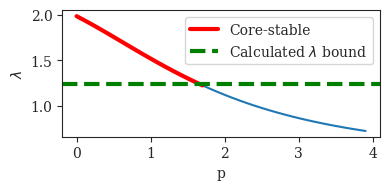

In [328]:
fig, ax = plt.subplots(figsize=(4,2))

ax.plot(q_list, lambda_list)

fair_condition = [index for index, element in enumerate(stable_list) if element == False]
ax.plot([q_list[i] for i in fair_condition] , [lambda_list[i] for i in fair_condition], color='red', linewidth=3, label='Core-stable')        
ax.axhline(y=lambda_cal, linewidth=3,color='green', linestyle='--',label='Calculated $\lambda$ bound')
plt.xlabel('p')
plt.ylabel('$\lambda$')
ax.legend() 
plt.tight_layout()
plt.savefig("fea_reg.svg")
plt.show()